# Learning to trace geometrical paths for faster Ray Tracing

TODO

In [1]:
from collections.abc import Iterator
from typing import Any, Optional

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from beartype import beartype as typechecker
from jaxtyping import Array, Bool, Float, Int, PRNGKeyArray, Shaped, jaxtyped
from tqdm.notebook import trange

from differt2d.geometry import ImagePath, Point, Wall
from differt2d.scene import Scene

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Problem definition

The goal of our model is to generate all the paths, of a given order, between TX and RX in a 2D scene.

Here, the

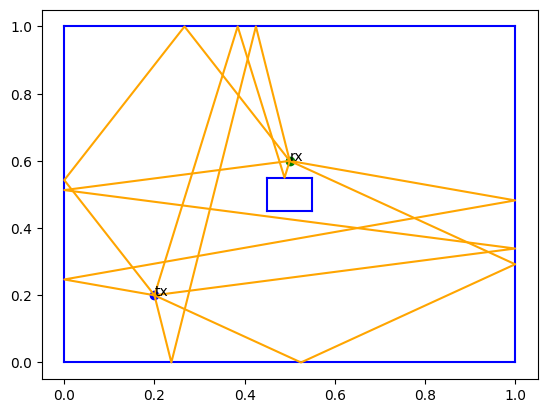

In [22]:
ax = plt.gca()
scene = Scene.square_scene_with_obstacle()
scene.plot(ax)

order = 2

for _, _, path, _ in scene.all_valid_paths(
    min_order=order, max_order=order, approx=False
):
    path.plot(ax)

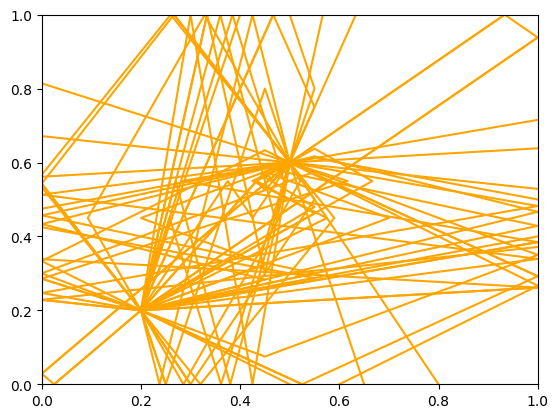

In [26]:
ax = plt.gca()

order = 2

ax.autoscale(False, axis="x")
ax.autoscale(False, axis="y")

for _, _, valid, path, _ in scene.all_paths(
    min_order=order, max_order=order, approx=False
):
    path.plot(ax)

## Training data generation

In [3]:
key = jax.random.PRNGKey(12345)
key, key_example_scene = jax.random.split(key, 2)


def random_scenes(
    *,
    key: PRNGKeyArray,
    min_ratio: float = 0.20,
    max_ratio: float = 0.30,
    min_num_walls: int = 4,
    min_angle: float = -0.05 * jnp.pi,
    max_angle: float = +0.05 * jnp.pi,
) -> Iterator[tuple[Scene, Float[Array, "2+num_walls*2 2"]]]:
    while True:
        key, key_ratio, key_tx_rx, key_num_walls, key_walls, key_angles = (
            jax.random.split(key, 6)
        )
        # A random scaling is applied to the inner square
        ratio = jax.random.uniform(key_ratio, minval=min_ratio, maxval=max_ratio)
        # TX and RX are randomly sampled
        points = jax.random.uniform(key_tx_rx, (2, 2))
        tx = Point(xy=points[0, :])
        rx = Point(xy=points[1, :])
        scene = Scene.square_scene_with_obstacle(ratio=ratio)
        center = scene.center()
        indices = jnp.arange(len(scene.objects), dtype=jnp.int32)
        # The number of walls is random
        num_walls = jax.random.randint(
            key_num_walls, (), minval=min_num_walls, maxval=len(scene.objects) + 1
        )
        # Walls are shuffled (to make sure deepset models is permutation invariant, but should not be needed)
        wall_indices = jax.random.choice(
            key_walls, indices, shape=(num_walls,), replace=False
        )
        # Each wall receives a random permutation around the center of the scene
        angles = jax.random.uniform(
            key_angles, shape=(num_walls,), minval=min_angle, maxval=max_angle
        )
        objects = [
            scene.objects[wall_index].rotate(angle=angle, around=center)
            for wall_index, angle in zip(wall_indices, angles)
        ]

        points = jnp.vstack([points, *[obj.xys for obj in objects]])

        yield (
            scene.with_transmitters(tx=tx).with_receivers(rx=rx).with_objects(*objects),
            points,
        )


def samples(
    order: int, **kwargs: Any
) -> Iterator[tuple[Float[Array, "2+num_walls*2 2"], Int[Array, "num_paths {order}"]]]:
    for scene, points in random_scenes(**kwargs):
        path_candidates = [
            path_candidate
            for _, _, _, path_candidate in scene.all_valid_paths(
                min_order=order, max_order=order, approx=False
            )
        ]

        # Handle edge case with no path
        if len(path_candidates) > 0:
            path_candidates = jnp.stack(path_candidates, dtype=jnp.int32)
        else:
            path_candidates = jnp.zeros((0, order), dtype=jnp.int32)

        yield points, path_candidates


scenes = random_scenes(key=key_example_scene)

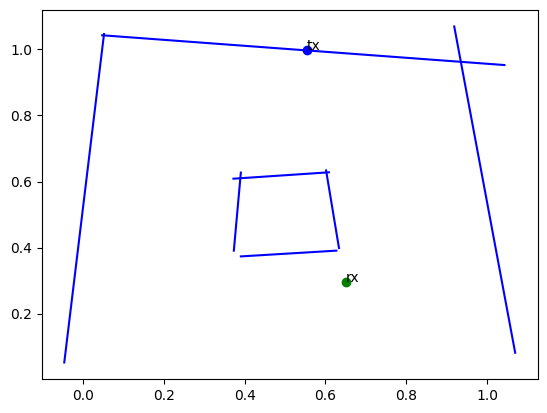

In [4]:
ax = plt.gca()
scene, _ = next(scenes)
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(
    min_order=order, max_order=order, approx=False
):
    path.plot(ax)

plt.show()

In [5]:
key, key_model, key_train, key_samples = jax.random.split(key, 4)
key_train_samples, key_test_samples = jax.random.split(key_samples, 2)

train_samples = samples(order=order, key=key_train_samples)
test_samples = samples(order=order, key=key_test_samples)

In [6]:
@jax.jit
@jaxtyped(typechecker=typechecker)
def row_in_matrix(
    row: Shaped[Array, " num_cols"], matrix: Shaped[Array, "num_rows num_cols"]
) -> Bool[Array, " "]:
    bool_ = jax.vmap(jnp.equal, in_axes=(None, 0))(row, matrix)
    return jnp.any(jnp.all(bool_, axis=1), axis=0)


@jax.jit
@jaxtyped(typechecker=typechecker)
def rows_in_matrix(
    rows: Shaped[Array, "batch num_cols"], matrix: Shaped[Array, "num_rows num_cols"]
) -> Bool[Array, " batch"]:
    return jax.vmap(row_in_matrix, in_axes=(0, None))(rows, matrix)


@jax.jit
@jaxtyped(typechecker=typechecker)
def reward(
    pred_path_candidates: Int[Array, "batch order"],
    true_path_candidates: Int[Array, "num_paths order"],
) -> Float[Array, " "]:
    # 1. Check if predicted path candidates are in the set of true path candidates
    pred_in_true = rows_in_matrix(pred_path_candidates, true_path_candidates)
    valid_count = jnp.sum(pred_in_true)
    invalid_count = jnp.sum(~pred_in_true)

    return jnp.where(true_path_candidates.size > 0, valid_count - invalid_count, 0.0)

In [7]:
# Example to show how the reward function works
pred_path_candidates = jnp.array(
    [[0, 1], [2, 3], [1, 2], [2, 3], [0, 1], [4, 5]], dtype=jnp.int32
)

confidences = jnp.array([1.0, 1.0, 0.5, 1.0, 0.0, 0.0])

true_path_candidates = jnp.array([[0, 1], [2, 3]], dtype=jnp.int32)

with jax.disable_jit():
    r = reward(pred_path_candidates, true_path_candidates)
    print(r)

2.0


# Model definition

In [8]:
class Model(eqx.Module):
    # Hyperparameters
    order: int = eqx.field(static=True)
    """The order of the path(s)."""
    hidden_size: int = eqx.field(static=True)
    """The hidden size of the GRU cell."""
    # Layers
    wall_2_embeddings: eqx.nn.MLP
    """MLP that is applied to each object in parallel and returns embeddings."""
    tx_rx_wall_walls_embeddings_and_state_2_prob: eqx.nn.MLP
    """MLP that maps each possible choice to some probability [0, 1]."""
    cell: eqx.nn.GRUCell
    """Recurrent cell."""

    def __init__(
        self,
        # Hyperparameters
        order: int = 1,
        tx_size: int = 2,
        rx_size: int = 2,
        wall_size: int = 4,
        wall_num_embeddings: int = 100,
        hidden_size: int = 100,
        *,
        key: PRNGKeyArray,
    ):
        if order < 0:
            raise ValueError(f"Order must be greater or equal to 0, got {order}.")

        key1, key2, key3 = jax.random.split(key, 3)

        # Hyperparameters
        self.order = order
        self.hidden_size = hidden_size

        # Layers
        self.wall_2_embeddings = eqx.nn.MLP(
            in_size=wall_size,
            out_size=wall_num_embeddings,
            width_size=500,
            depth=1,
            key=key1,
        )
        self.tx_rx_wall_walls_embeddings_and_state_2_prob = eqx.nn.MLP(
            in_size=tx_size + rx_size + wall_size + wall_num_embeddings + hidden_size,
            out_size="scalar",
            width_size=500,
            depth=1,
            final_activation=jax.nn.relu,
            key=key2,
        )
        self.cell = eqx.nn.GRUCell(
            input_size=wall_num_embeddings,
            hidden_size=hidden_size,
            key=key3,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        xys: Float[Array, "two_plus_num_walls_times_two 2"],
        *,
        key: Optional[PRNGKeyArray] = None,
    ) -> Int[Array, "{self.order}"]:
        assert xys.shape[0] >= 2, "Scene must at least have two points: tx and rx."

        # Data normalization
        eps = 1e-5
        mean = jnp.mean(xys, axis=0, keepdims=True)
        std = jnp.std(xys, axis=0, keepdims=True)

        xys = (xys - mean) / (std + eps)

        # [2]
        tx = xys[0, :]
        rx = xys[1, :]

        # [num_walls, 2x2]
        walls = xys[2:, :].reshape(-1, 4)
        num_walls = walls.shape[0]

        #jax.debug.print("num_walls = {num_walls}", num_walls=num_walls)

        # Handle empty scene
        if walls.size == 0:
            if self.order == 0:
                return (
                    jnp.empty(0, dtype=jnp.int32),
                    jnp.array(1.0),
                    prev_state,
                )  # One path candidate of size 0, but it does not make sense to use this model for order < 1
            else:
                return (
                    jnp.empty(self.order, dtype=jnp.int32),
                    jnp.array(0.0),
                    prev_state,
                )  # Zero path candidate of size order, so we return a 0 confidence

        walls_embeddings = jax.vmap(self.wall_2_embeddings)(walls)
        sum_walls_embeddings = jnp.sum(walls_embeddings, axis=0)

        Carry = tuple[Float[Array, " hidden_size"], Int[Array, " "]]
        Index = Int[Array, " "]

        @jaxtyped(typechecker=typechecker)
        def scan_fn(carry: Carry, key: PRNGKeyArray) -> tuple[Carry, Index]:
            state, prev_index = carry
            key_choice, key_dropout = jax.random.split(key, 2)
            probs = jax.vmap(
                lambda wall: self.tx_rx_wall_walls_embeddings_and_state_2_prob(
                    jnp.concatenate((tx, rx, wall, sum_walls_embeddings, state))
                )
            )(walls)
            #jax.debug.print("p = {probs}", probs=probs)
            probs = jnp.where(
                prev_index < num_walls,
                probs.at[prev_index].set(
                    0.0
                ),  # We avoid selecting the same index twice in a row
                probs,
            )
            #probs = self.dropout(probs, key=key_dropout)
            #jax.debug.print("num_walls = {num_walls}, p = {probs}", num_walls=num_walls, probs=probs)
            index = jax.random.choice(key=key_choice, a=num_walls, p=probs)

            state = self.cell(walls_embeddings[index, :], state)
            #jax.debug.print("a. returning index = {index}", index=index)
            index = index.astype(jnp.int32)

            #jax.debug.print("returning index = {index}", index=index)

            return (state, index), index

        init_state = jnp.zeros(self.hidden_size)

        prev_index = jnp.array(num_walls, dtype=jnp.int32)
        init = (init_state, prev_index)

        _, path_candidate = jax.lax.scan(
            scan_fn, init, xs=jax.random.split(key, self.order)
        )

        return path_candidate

## Loss function definition

In [9]:
@jaxtyped(typechecker=typechecker)
def loss(
    model: Model,
    xys: Float[Array, "two_plus_num_walls_times_two 2"],
    true_path_candidates: Int[Array, "num_paths order"],
    batch: int = 10,
    plot: bool = False,
    *,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.
    """

    @jaxtyped(typechecker=typechecker)
    def scan_fn(_init: tuple, key: PRNGKeyArray) -> tuple[tuple, Int[Array, " order"]]:
        pred_path_candidate = model(xys, key=key)

        return (), pred_path_candidate

    _, pred_path_candidates = jax.lax.scan(scan_fn, (), xs=jax.random.split(key, batch))

    if plot:
        order = model.order
        tx = Point(xy=xys[0, :])
        rx = Point(xy=xys[1, :])
        walls = xys[2:].reshape(-1, 2, 2)
        scene = Scene(
            transmitters={"tx": tx},
            receivers={"rx": rx},
            objects=[Wall(xys=wall) for wall in walls],
        )
        ax = plt.gca()
        scene.plot(ax)

        for _, _, path, _ in scene.all_valid_paths(
            min_order=order, max_order=order, approx=False
        ):
            path.plot(ax, color="orange")

        if len(walls) > 0:
            print(pred_path_candidates)
            for pred_path_candidate in jnp.unique(pred_path_candidates, axis=0):
                objects = [scene.objects[i] for i in pred_path_candidate]
                ImagePath.from_tx_objects_rx(tx, objects, rx).plot(
                    ax, linestyle="--", alpha=0.5, color="red"
                )

    return - reward(pred_path_candidates, true_path_candidates)

In [10]:
training_model = Model(order=order, key=key_model)
optim = optax.adam(learning_rate=3e-4)

[[3 2]
 [0 3]
 [1 4]
 [2 4]
 [3 1]
 [0 3]
 [3 2]
 [0 1]
 [1 3]
 [1 4]]


Array(10., dtype=float32, weak_type=True)

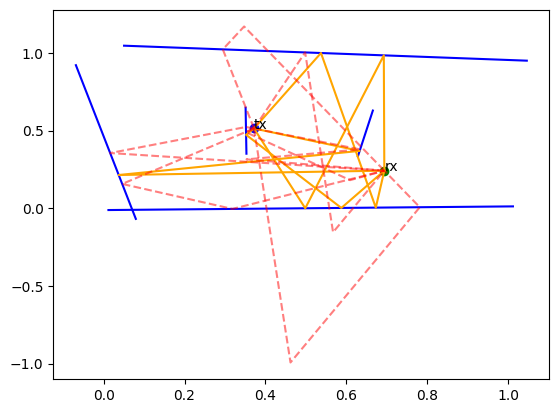

In [11]:
loss(training_model, *next(train_samples), plot=True, key=key)  # Untrained model

In [12]:
def train(
    model: Model
ax.autoscale(False, axis="x")
ax.autoscale(False, axis="y"),
    train_samples: Iterator,
    test_samples: Iterator,
    optim: optax.GradientTransformation,
    steps: int = 100_000,
    print_every: int = 1_000,
    num_test_samples: int = 100,
    *,
    key: PRNGKeyArray,
) -> tuple[Model, Float[Array, "{steps}"]]:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: Model,
        opt_state: optax.OptState,
        xys: Float[Array, "2+num_walls*2 2"],
        true_path_candidates: Float[Array, "num_paths order"],
        *,
        key: PRNGKeyArray,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, xys, true_path_candidates, key=key
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    test_losses = []

    jitted_loss = eqx.filter_jit(loss)

    with trange(steps, desc="", unit=" steps", leave=True) as bar:
        for step, (x_train, y_train) in zip(bar, train_samples):
            key, key_step = jax.random.split(key, 2)

            model, opt_state, train_loss = make_step(
                model, opt_state, x_train, y_train, key=key_step
            )
            if (step % print_every) == 0 or (step == steps - 1):
                test_loss = 0
                for _, (x_test, y_test) in zip(
                    range(num_test_samples),
                    test_samples,
                ):
                    key, key_test = jax.random.split(key, 2)
                    test_loss += jitted_loss(model, x_test, y_test, key=key_test)
                test_loss /= num_test_samples

                bar.set_description(
                    f"train_loss = {float(train_loss):.1f}, test_loss = {float(test_loss):.1f}"
                )
                test_losses.append(test_loss)

    return model, jnp.array(test_losses)

  0%|          | 0/100000 [00:00<?, ? steps/s]

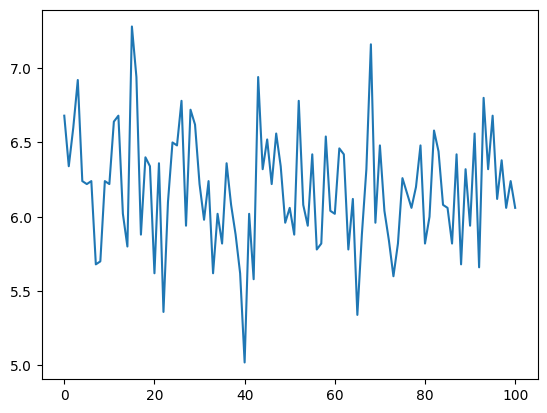

In [13]:
training_model, losses = train(
    training_model, train_samples, test_samples, optim, key=key_train
)
inference_model = eqx.nn.inference_mode(training_model)

plt.plot(losses)

[[4 5]
 [0 2]
 [6 5]
 [3 5]
 [0 3]
 [2 5]
 [5 1]
 [0 2]
 [2 3]
 [0 3]]


Array(-0., dtype=float32, weak_type=True)

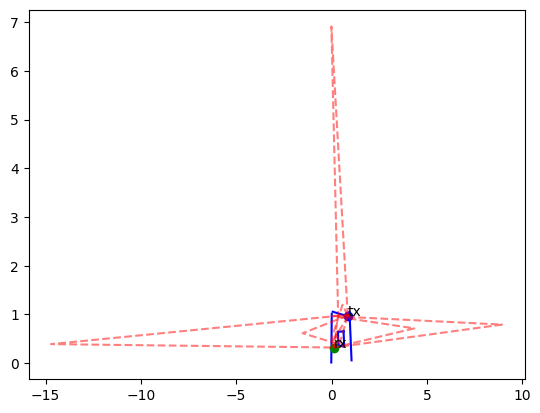

In [14]:
key, key_test_inference = jax.random.split(key, 2)

loss(inference_model, *next(test_samples), plot=True, key=key_test_inference)